In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
%matplotlib inline

pd.set_option('display.max_columns',80)

#### Import the data and create separate dataframes for each cover type to explore the various combos in depth

In [2]:
forest = pd.read_csv('data/train.csv', header=0, index_col=0) #Use the Id column as an index...why not
forest.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


#### Visualize

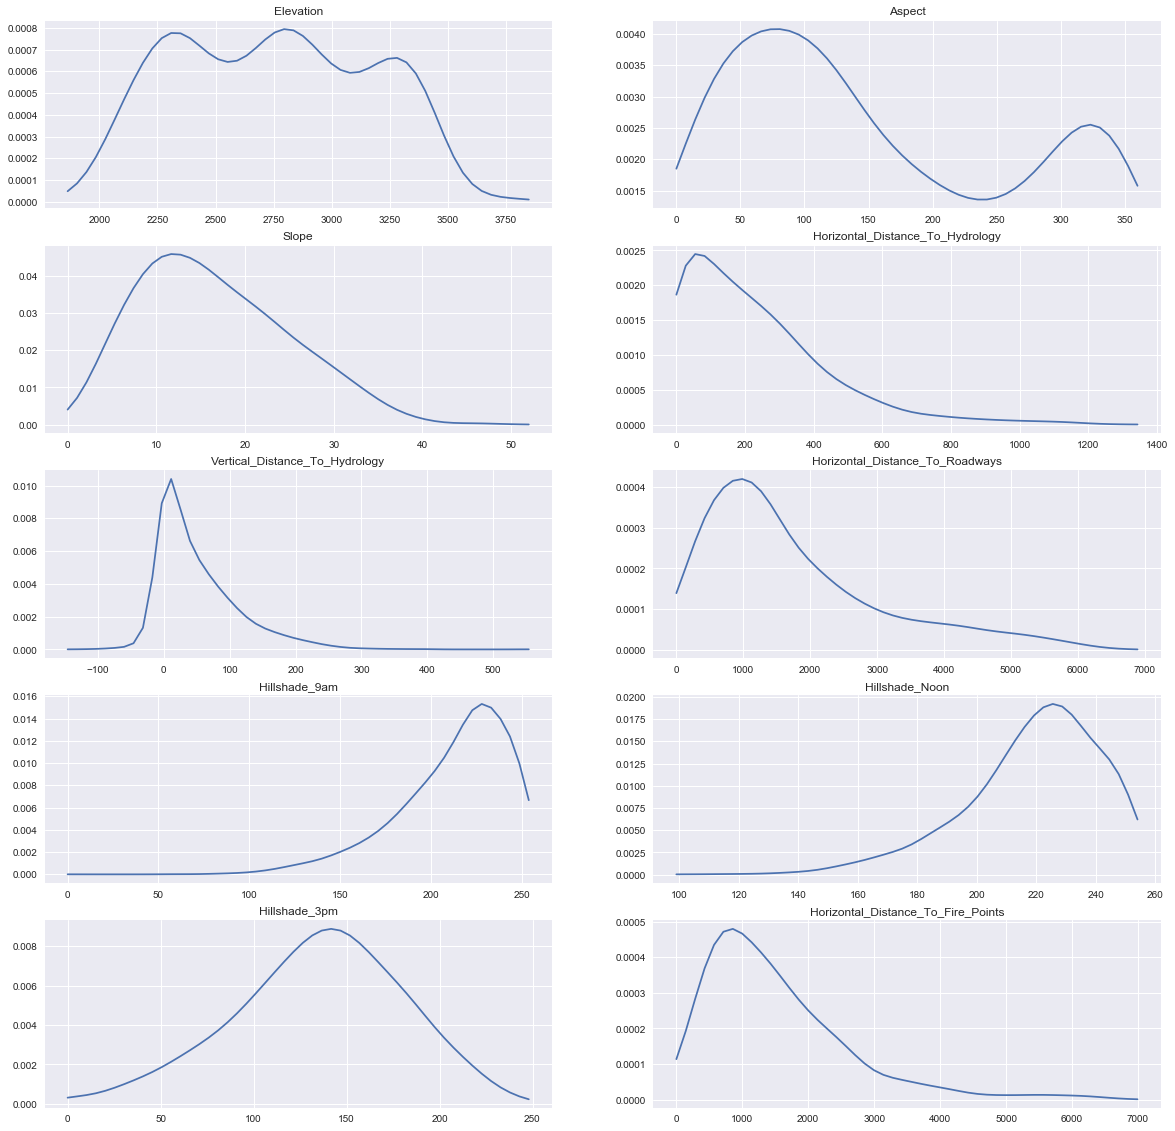

In [3]:
cont_columns = forest.columns[0:10]
    
#fig = plt.figure(figsize=(10,10))
#for col in cont_columns:
#    ax = fig.add_subplot(221)
#    ax = sns.kdeplot(forest[col])
    
mpl_density = plt.figure(figsize=(20,20))
i=1
for col in cont_columns:
    plt.subplot(5,2,i)
    plt.title(col)
    data = forest[col]
    density = gaussian_kde(data)
    x_axis = np.linspace(np.min(data), np.max(data))
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(x_axis,density(x_axis))
    i+=1

plt.savefig('visualizations/continuous_parameters_kde.jpg')
plt.show()

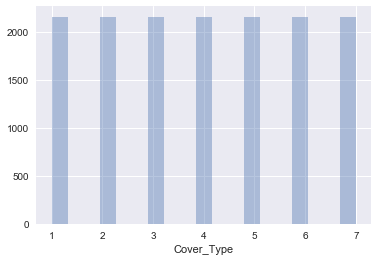

In [4]:
sns.distplot(forest.Cover_Type, kde=False);

# There is an equal distribution among the cover types in the training data

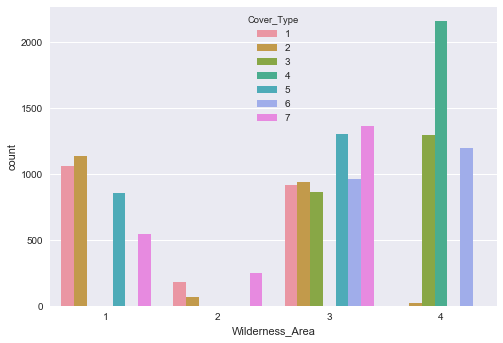

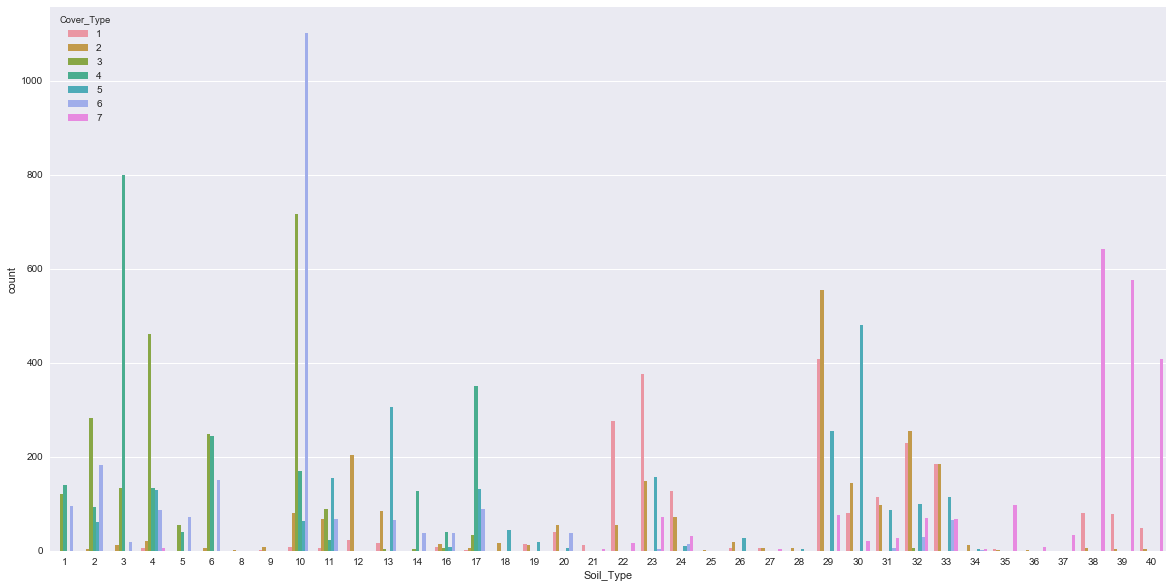

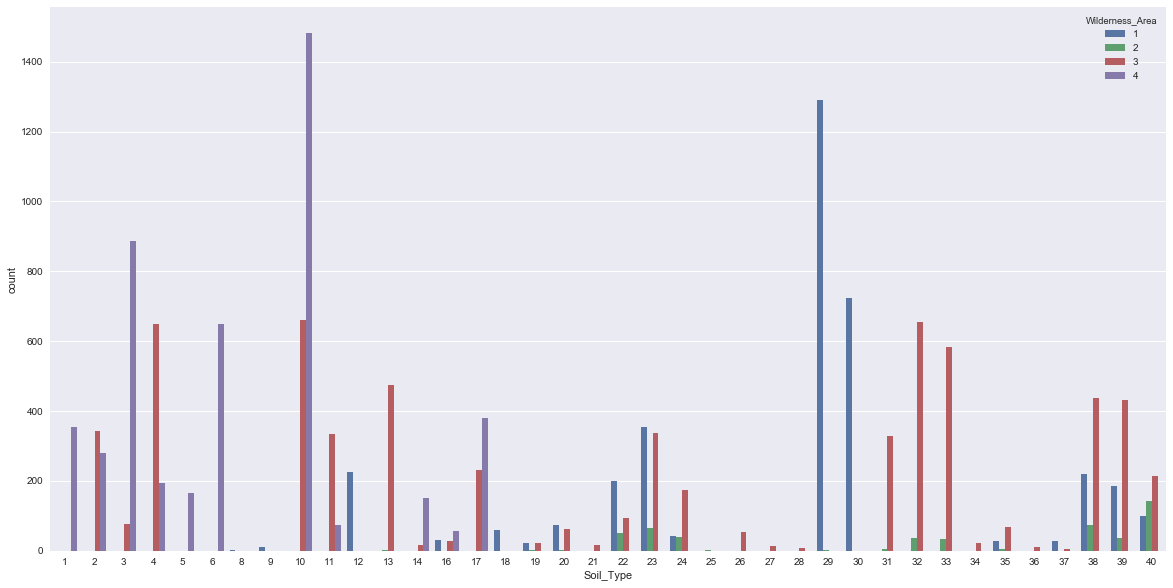

In [5]:
cols = forest.columns
n_rows, n_cols = forest.shape

grouped_forest = pd.DataFrame(index=np.arange(0, n_rows),columns=['Wilderness_Area','Soil_Type','Cover_Type'])

#Make an entry in 'data' for each r as category_id, target value
for i in range(0,n_rows):
    wild=0;
    soil=0;
    # Wilderness Area range
    for j in range(10,14):
        if (forest.iloc[i,j] == 1):
            wild=j-9  #category class
            break
    # Soil Type range        
    for k in range(14,54):
        if (forest.iloc[i,k] == 1):
            soil=k-13 #category class
            break
    #Make an entry in 'data' for each r as category_id, target value        
    grouped_forest.iloc[i]=[wild,soil,forest.iloc[i,n_cols-1]]

sns.set(style="darkgrid")

# plot wilderness area with respect to cover type
sns.countplot(x="Wilderness_Area", hue="Cover_Type", data=grouped_forest)
plt.show()

# plot soil type with respect to cover type
plt.rc("figure", figsize=(20,10))
sns.countplot(x="Soil_Type", hue="Cover_Type", data=grouped_forest)
plt.show()
# plot soil type with respect to wilderness area
sns.countplot(x="Soil_Type", hue="Wilderness_Area", data=grouped_forest)
plt.show()

# Wilderness area 4 and cover type 4 have a lot of cooccurrences
# Wilderness area 3 doesn't have much class distinction
# Wilderness area 2 doesn't have many hits at all

# Soil types 2,3,4,6,10,12,13,17,22,23,29,30,32,38,39,40 have a fair amount of class distinction
#Soil Types 7 and 15 can definitely be removed as they offer no information

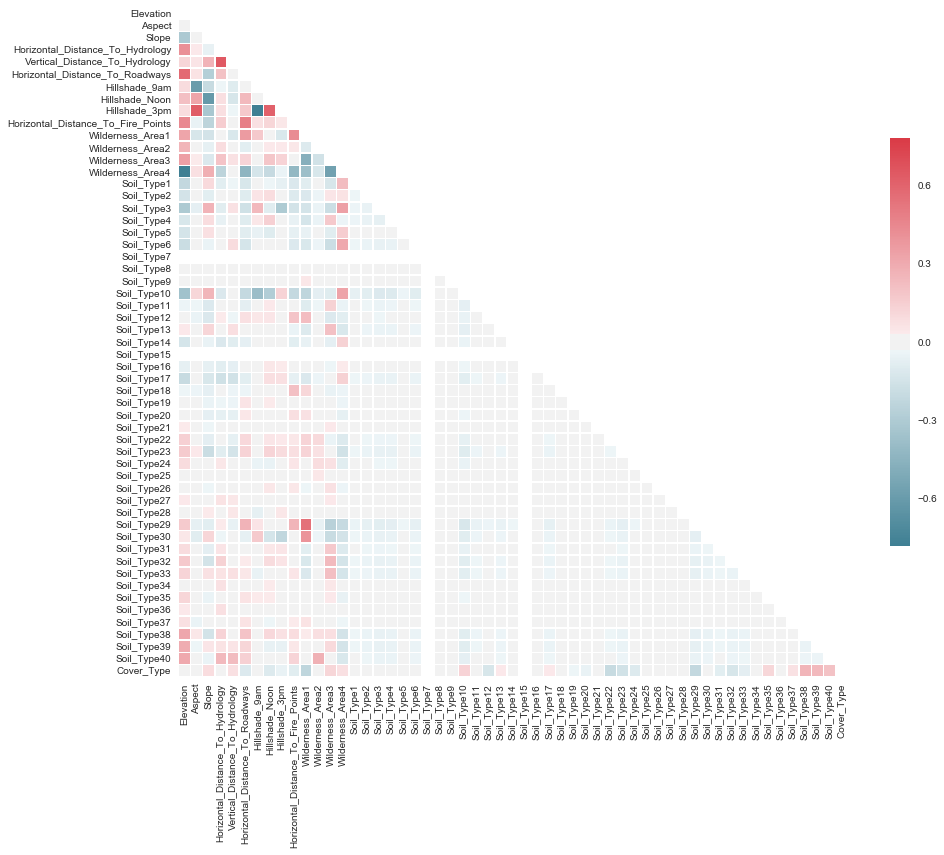

In [6]:
sns.set(style="white")
f, ax = plt.subplots(figsize=(15, 15))

correlation = forest.corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
rd_bl_map = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=rd_bl_map, vmax=.3, square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);
plt.savefig('visualizations/feature_correlation.png')

#Soil Types 7 and 15 can definitely be removed as they offer no information as can be seen.

In [8]:
corr_list = []
cols = forest.columns
c_threshold = .5
for i in range(0,len(cols)):
    for j in range(i+1,len(cols)): #avoid repetition
        if (correlation.iloc[i,j] >= c_threshold and correlation.iloc[i,j] < 1) or (correlation.iloc[i,j] < 0 and correlation.iloc[i,j] <= -c_threshold):
            corr_list.append([correlation.iloc[i,j],i,j])

#Sort to show higher ones first            
corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))

#Print correlations and column names
for v,i,j in corr_list:
    print ("%s and %s = %.2f" % (cols[i],cols[j],v))

Elevation and Wilderness_Area4 = -0.78
Hillshade_9am and Hillshade_3pm = -0.78
Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology = 0.65
Aspect and Hillshade_3pm = 0.64
Hillshade_Noon and Hillshade_3pm = 0.61
Slope and Hillshade_Noon = -0.61
Aspect and Hillshade_9am = -0.59
Elevation and Horizontal_Distance_To_Roadways = 0.58
Wilderness_Area3 and Wilderness_Area4 = -0.57
Wilderness_Area1 and Soil_Type29 = 0.55


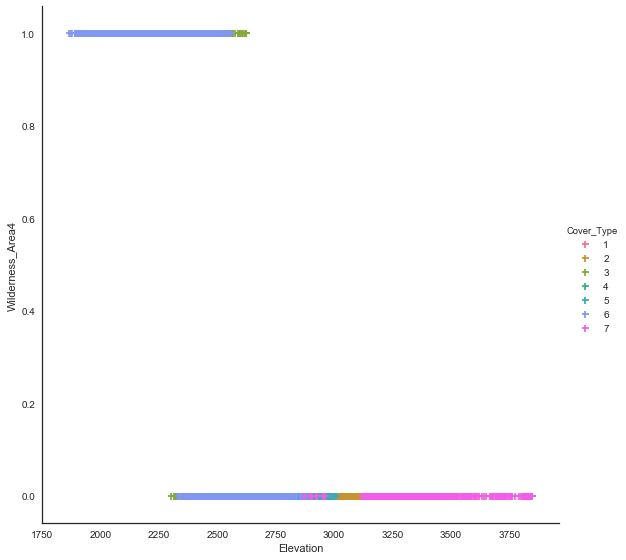

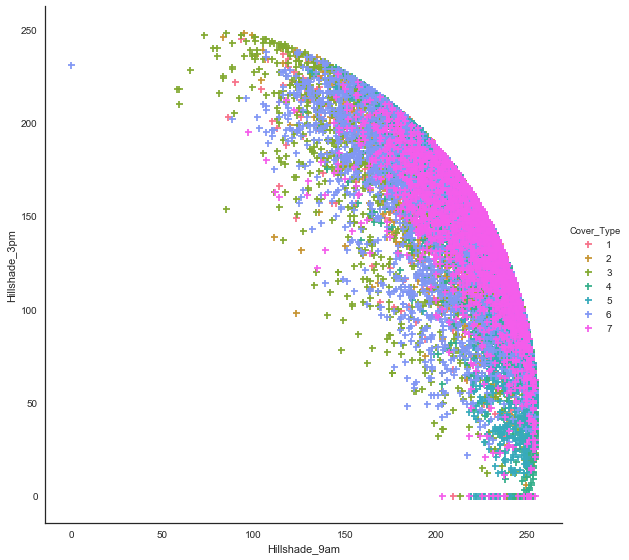

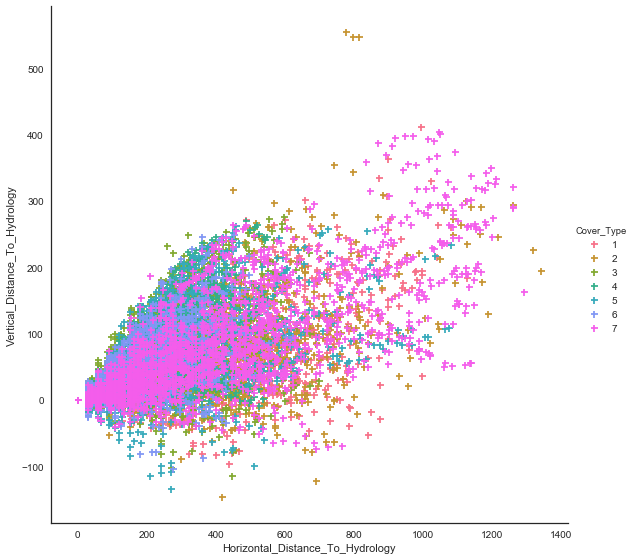

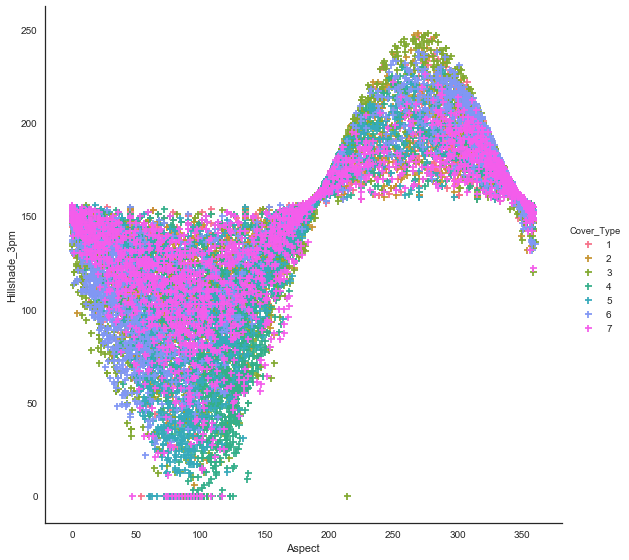

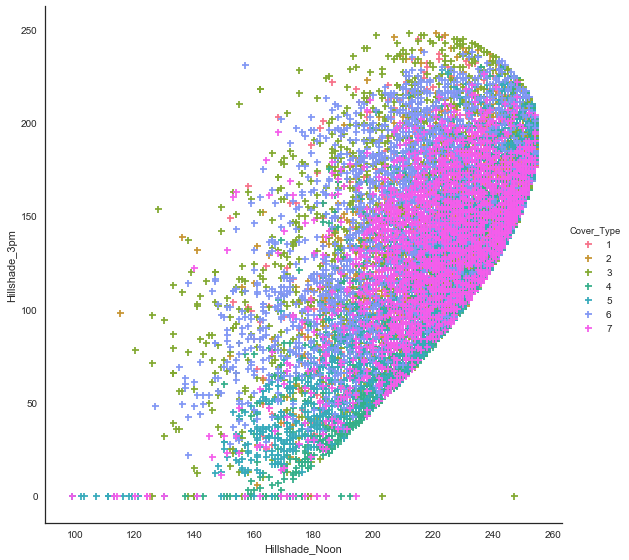

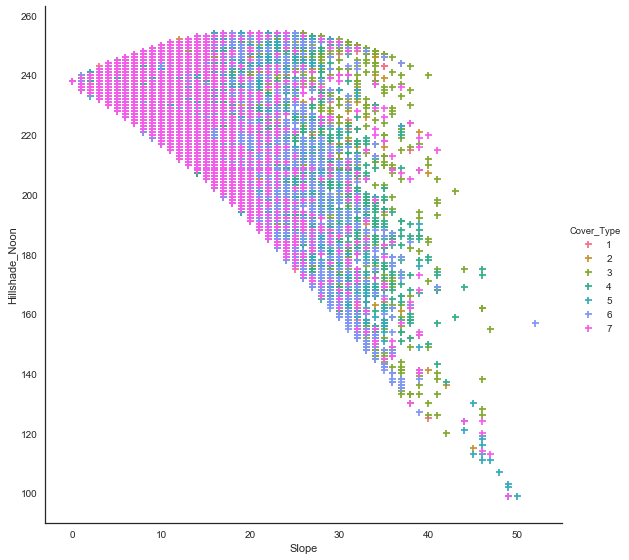

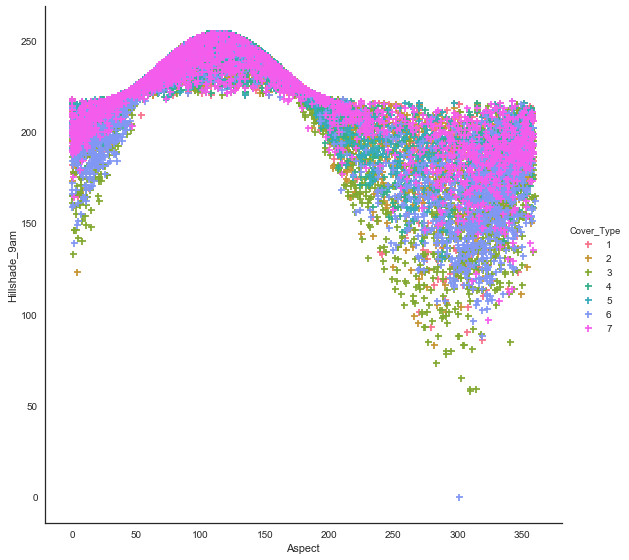

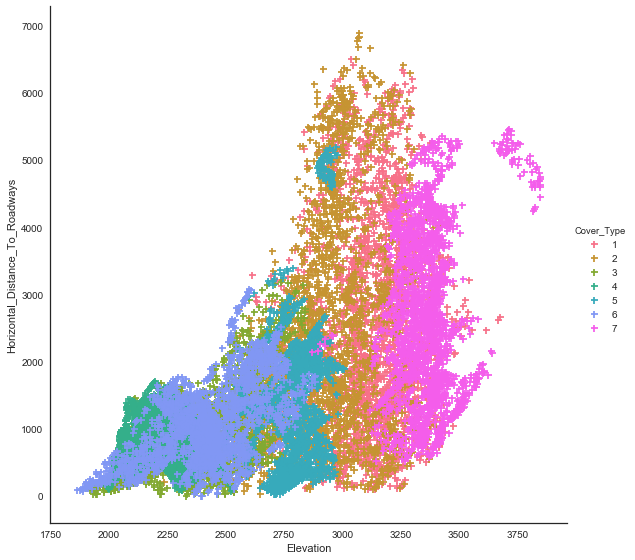

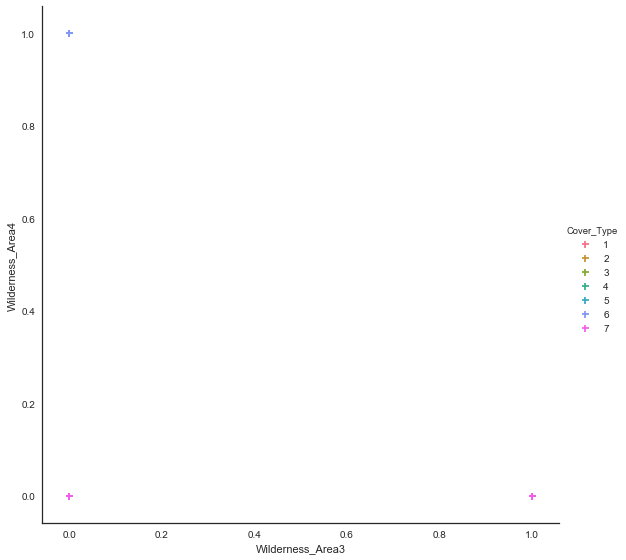

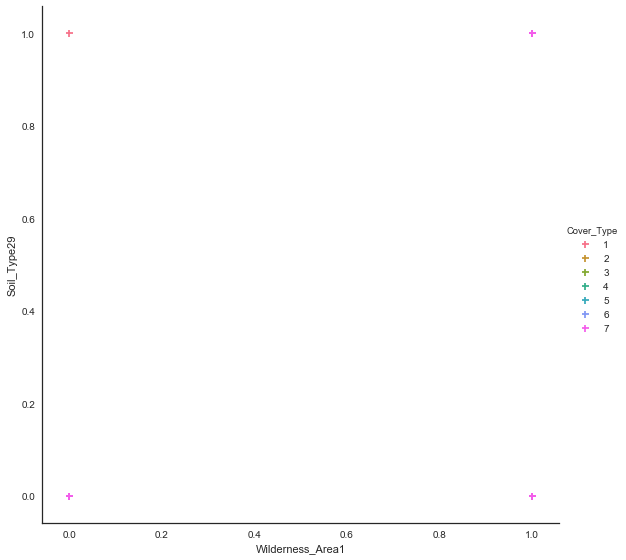

In [9]:
for v,i,j in corr_list:
    sns.pairplot(forest, hue="Cover_Type", size=8, x_vars=cols[i], y_vars=cols[j], markers='+')
    if cols[i] == 'Elevation' and cols[j] == 'Horizontal_Distance_To_Roadways':
        plt.savefig('visualizations/elevation_horizontal_roadways.png')
    plt.show()
    
#The plots show to which class does a point belong to. The class distribution overlaps in the plots.    
#Hillshade patterns have ellipsoid patterns when comparing to each other
#Aspect and Hillshades attributes form a sigmoid pattern
#Horizontal and vertical distance to hydrology give an almost linear pattern.

#### Cover Type Exploration

In [9]:
covers = [forest[forest.Cover_Type==i] for i in range(1,8)]
covers[0].head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
41,2699,347,3,0,0,2096,213,234,159,6853,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
52,2739,323,25,85,43,3118,149,205,192,6219,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
53,2696,72,2,30,0,3271,222,234,149,6071,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
56,2722,315,24,30,19,3216,148,212,200,6132,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
68,2919,13,13,90,6,5321,207,214,142,4060,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


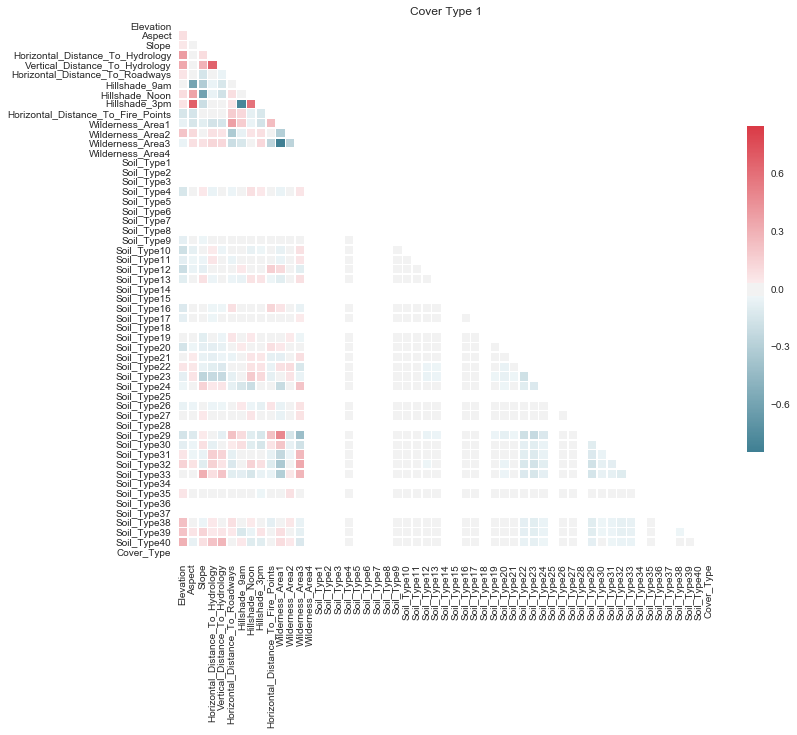

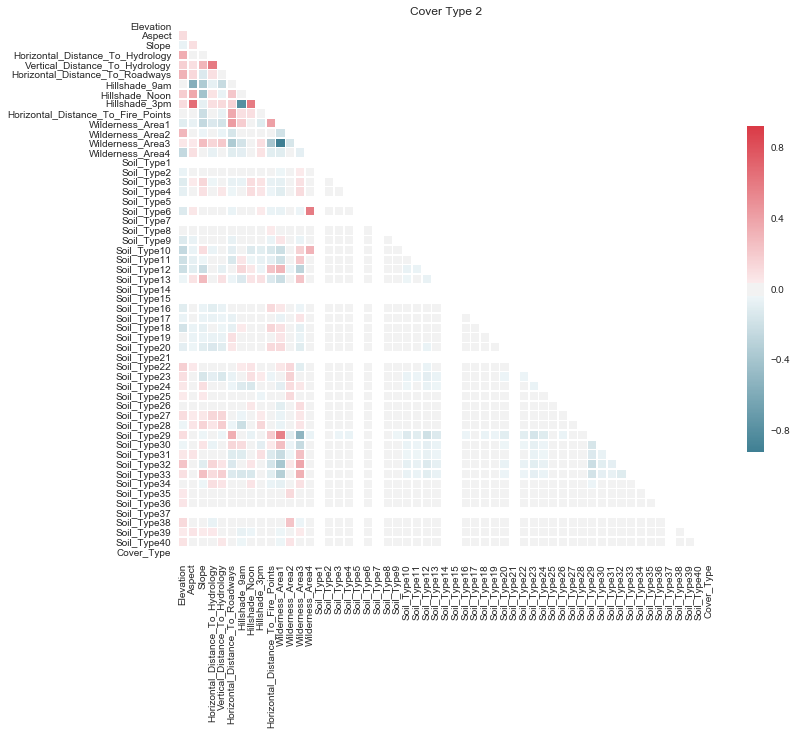

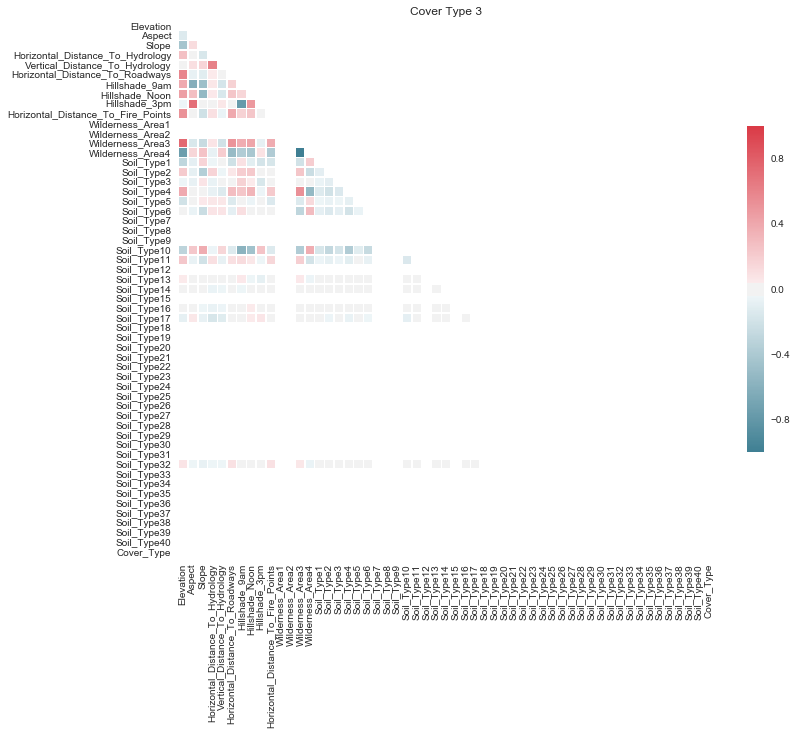

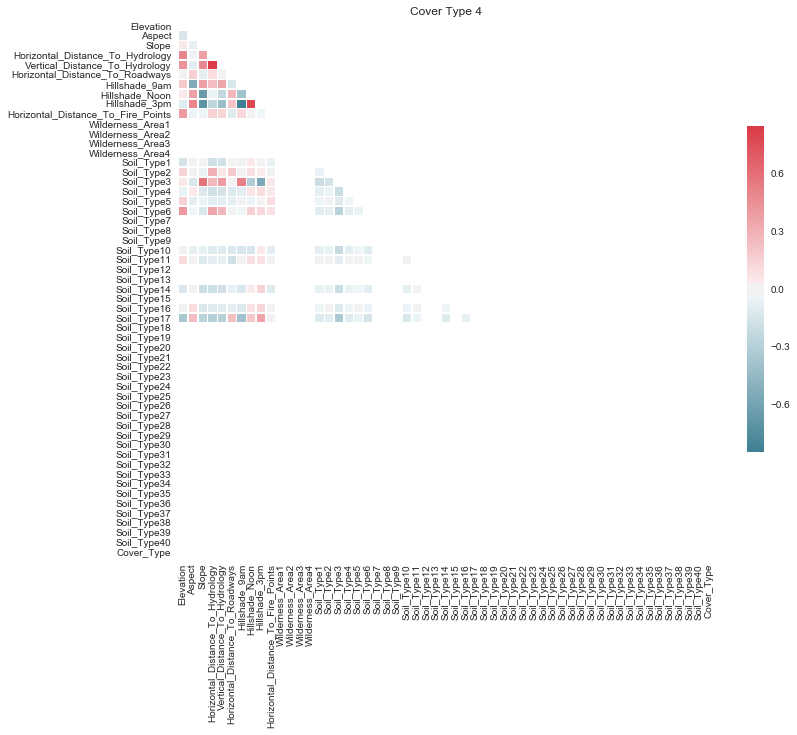

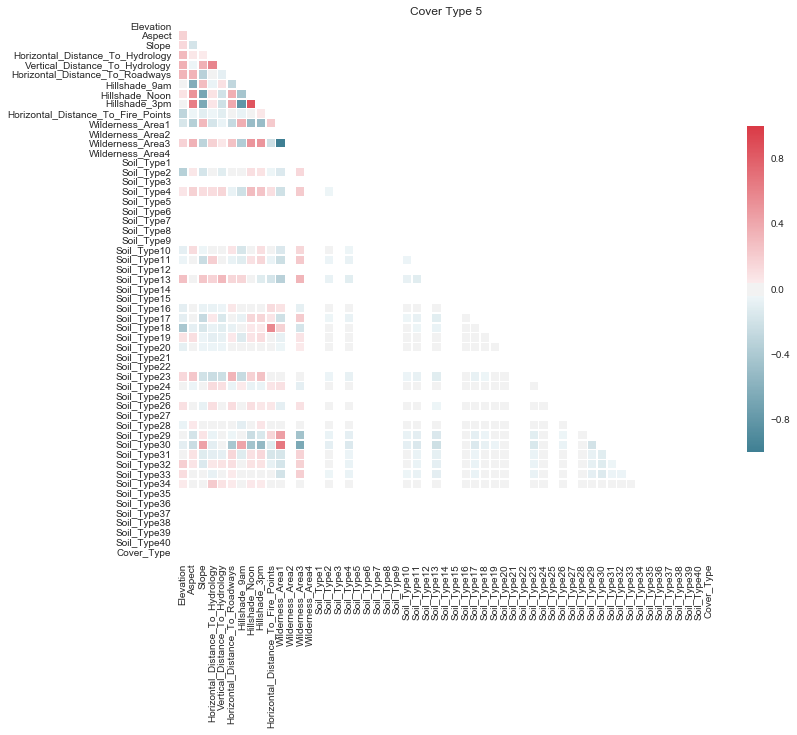

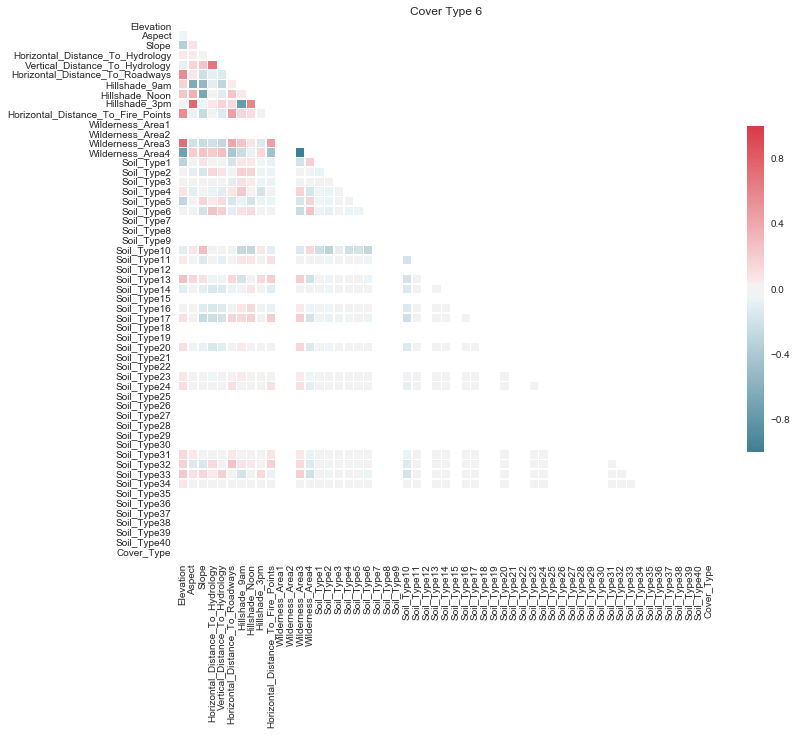

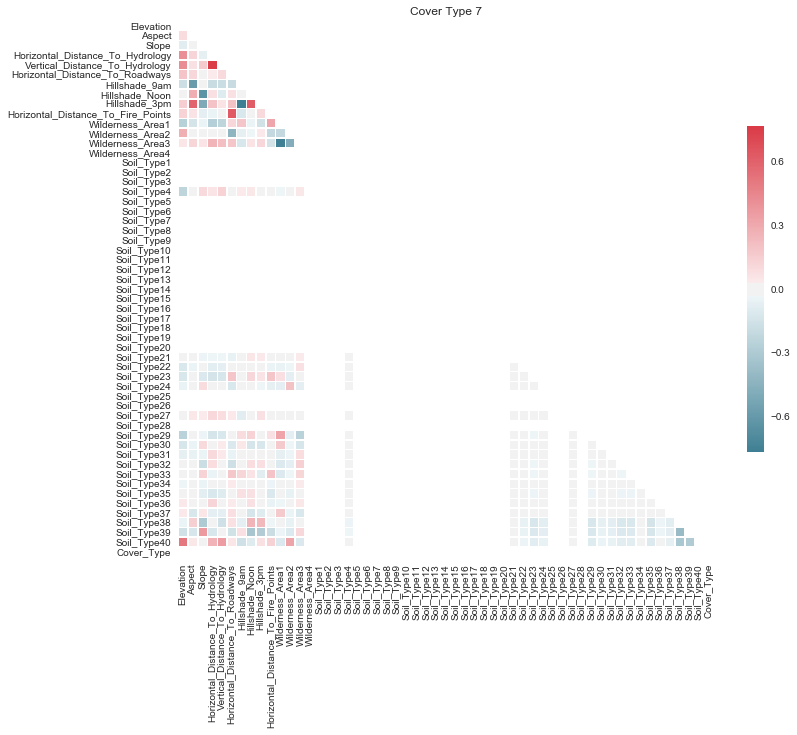

In [10]:
cover_titles = ['Cover Type 1', 'Cover Type 2', 'Cover Type 3', 'Cover Type 4', 'Cover Type 5', 'Cover Type 6', 'Cover Type 7']
for i in range(len(covers)):
    sns.set(style="white")
    f, ax = plt.subplots(figsize=(12,12))
    plt.title(cover_titles[i])
    correlation = covers[i].corr()
    mask = np.zeros_like(correlation, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    rd_bl_map = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlation, mask=mask, cmap=rd_bl_map, vmax=.3, square=True, 
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

# Doesn't effect Cover Type 1: WA4, Soil 1,2,3,5,6,7,8,14,15,18,25,28,34,36,37

In [11]:
corr_dict = dict()
cols = forest.columns
c_threshold = .5
for c in range(len(covers)):
    print ('Correlations for %s' %(covers_titles[c]))
    corr_list = []
    correlation = covers[c].corr()
    for i in range(0,len(cols)):
        for j in range(i+1,len(cols)): #avoid repetition
            if (correlation.iloc[i,j] >= c_threshold and correlation.iloc[i,j] < 1) or (correlation.iloc[i,j] < 0 and correlation.iloc[i,j] <= -c_threshold):
                corr_list.append([correlation.iloc[i,j],i,j])
    corr_dict[c] = corr_list

    # Sort to show more highly correlated features first
    corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))

    # Print correlations and column names
    for v,i,j in corr_list:
        print ("%s and %s = %.2f" % (cols[i],cols[j],v))
    print ("\n")

NameError: name 'covers_titles' is not defined